In [35]:
import numpy as np
import pandas as pd
from opt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

### Download and Load the Raw Races Dataset

In [2]:
url = "http://personal.psu.edu/drh20/code/btmatlab/nascar2002.txt"
races_trimmed = pd.read_table(url, sep=" ")

### Create the Complete Dataset

- Most drivers do not race all of the races, 
- We need to create a dataset with every combination of all drivers/ races so that we can take pairwise differences consistently

In [3]:
# Create a cartesian product of unique drivers and races to get every combination
unq_drivers = sorted(races_trimmed["DriverID"].unique())
unq_drivers = [x for x in unq_drivers if str(x) != 'nan']
unq_races = sorted(races_trimmed["Race"].unique())
unq_races = [x for x in unq_races if str(x) != 'nan']

# Get a dataframe 
unq_drivers_df = pd.DataFrame(unq_drivers, columns=["DriverID"])
unq_races_df = pd.DataFrame(unq_races, columns=["Race"])

# Let's cross join the columns to get all unique combinations of drivers and races
all_driver_race_combs = unq_drivers_df.assign(foo=1).merge(unq_races_df.assign(foo=1)).drop('foo', 1)
all_driver_race_combs = all_driver_race_combs.sort_values(by=['Race', 'DriverID'])
all_driver_race_mg = pd.merge(all_driver_race_combs, races_trimmed,  how='left', 
                              left_on=['DriverID','Race'], right_on = ['DriverID','Race'])

### For a single race calculate the pairwise differences

In [4]:
def pawise_ind(val):
    if np.isnan(val):
        out = val
    else:
        out = (val < 0) * 1
    return out

def difference_matrix(a):
    """ Get the pairwise differences in all quantities in a 1D-numpy array
    Source: https://stackoverflow.com/questions/22863547/numpy-compute-all-possible-differences-in-an-array-at-fixed-distance"""
    x = np.reshape(a, (len(a), 1))
    return x - x.T

def get_single_race_pwise(race_num, src_dat):
    """Get all pairwise race comparisons for a single race"""
    
    race_res = all_driver_race_mg[all_driver_race_mg["Race"] == race_num]
    race_res = race_res.sort_values(by=['DriverID'])
    race_res_val = race_res.values[:, 2]
    
    vpawise_ind = np.vectorize(pawise_ind)
    pwise_diff = difference_matrix(race_res_val)
    #pwise_diff = vpawise_ind(pwise_diff)
    
    return pwise_diff

def get_all_pwise_comb(src_dat):
    unq_races = sorted(src_dat["Race"].unique())
    all_pwise_races = [get_single_race_pwise(race_num=race, src_dat=src_dat) for race in unq_races]
    return np.dstack(all_pwise_races)

## Get pairwise differences for all Drivers for a single race

In [5]:
race_16_diffs = get_single_race_pwise(race_num=16.0, src_dat=all_driver_race_mg)
race_16_diffs.shape

(83, 83)

## Get pairwise differences for all competitors and all races

In [6]:
all_pwise = get_all_pwise_comb(src_dat=all_driver_race_mg)
all_pwise.shape

(83, 83, 36)

In [7]:
all_pwise[1]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [-21.,   2., -35., ...,   1.,   1.,  -3.],
       ...,
       [ nan,  nan,  nan, ...,  nan, -13.,  nan],
       [-32.,   7.,   3., ...,  25.,  22., -11.],
       [ 10.,  -2., -13., ...,  -1.,  11.,  -5.]])

In [19]:
all_pwise.shape

(83, 83, 36)

In [30]:
game_matrix_list = []
for i in range(all_pwise.shape[2]):
    pwise_diff = all_pwise[:,:,i]
    pwise_diff[pwise_diff <= 0] = 1
    pwise_diff[pwise_diff < 0] = 0
    pwise_diff[np.isnan(pwise_diff)] = 0
    game_matrix_list.append(pwise_diff)
game_matrix_list = np.array(game_matrix_list)

d:\python35\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in less_equal
d:\python35\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in less


In [31]:
game_matrix_list.shape

(36, 83, 83)

## Fit the model with squared l2-penalty

### Fit with small penalty

In [54]:
# optimization parameters
l_penalty = 2
max_iter = 1000
ths = 1e-12
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

### Newton

In [55]:
data = game_matrix_list

# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2]).reshape((N * T,1))
step_size = 1

# initialize record
objective_nt = [objective_l2_sq(beta, data, l_penalty)]
print("initial objective value: %f"%objective_nt[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = grad_l2_sq(beta, data, l_penalty)[1:]
    hessian = hess_l2_sq(beta, data, l_penalty)[1:,1:]
    
    # newton update
    beta[1:] = beta[1:] - step_size * sc.linalg.solve(hessian, gradient)
    
    # objective value
    objective_nt.append(objective_l2_sq(beta, data, l_penalty))
    
    print("%d-th Newton, objective value: %f"%(i+1, objective_nt[-1]))
    if objective_nt[-2] - objective_nt[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 409584.134729
1-th Newton, objective value: 204798.354993
2-th Newton, objective value: 180966.960681
3-th Newton, objective value: 177685.429431
4-th Newton, objective value: 177440.265034
5-th Newton, objective value: 177401.598575
6-th Newton, objective value: 177395.148118
7-th Newton, objective value: 177394.648094
8-th Newton, objective value: 177394.638833
9-th Newton, objective value: 177394.638824
10-th Newton, objective value: 177394.638824
Converged!


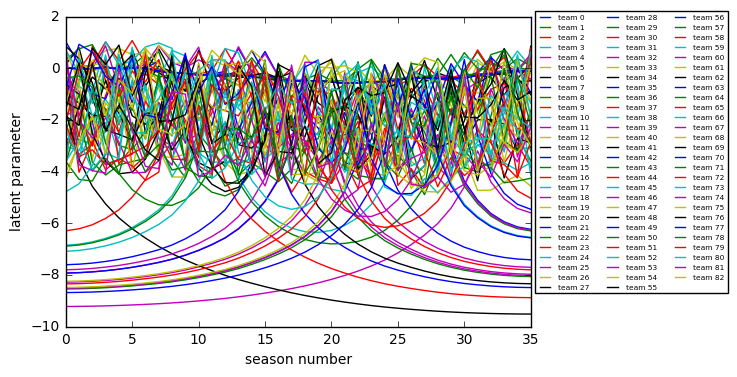

In [56]:
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 5.4},ncol = 3)

### Fit with large penalty

In [43]:
# optimization parameters
l_penalty = 2000
max_iter = 1000
ths = 1e-12
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

In [33]:
data.shape

(36, 83, 83)

### Newton

In [44]:
data = game_matrix_list

# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2]).reshape((N * T,1))
step_size = 1

# initialize record
objective_nt = [objective_l2_sq(beta, data, l_penalty)]
print("initial objective value: %f"%objective_nt[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = grad_l2_sq(beta, data, l_penalty)[1:]
    hessian = hess_l2_sq(beta, data, l_penalty)[1:,1:]
    
    # newton update
    beta[1:] = beta[1:] - step_size * sc.linalg.solve(hessian, gradient)
    
    # objective value
    objective_nt.append(objective_l2_sq(beta, data, l_penalty))
    
    print("%d-th Newton, objective value: %f"%(i+1, objective_nt[-1]))
    if objective_nt[-2] - objective_nt[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 409584.134729
1-th Newton, objective value: 314980.390213
2-th Newton, objective value: 311299.812822
3-th Newton, objective value: 311174.046053
4-th Newton, objective value: 311167.041120
5-th Newton, objective value: 311166.894028
6-th Newton, objective value: 311166.893918
7-th Newton, objective value: 311166.893918
8-th Newton, objective value: 311166.893918
Converged!


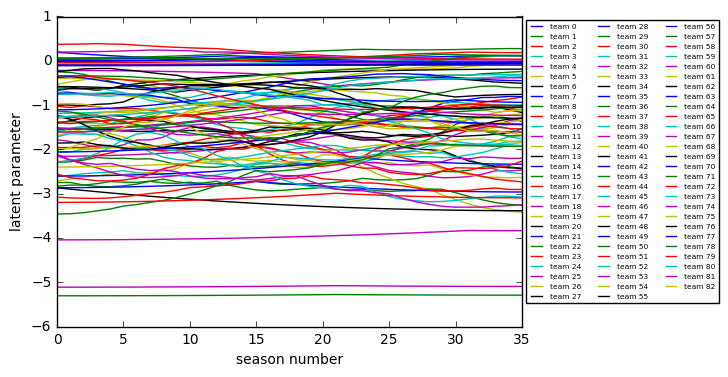

In [52]:
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1, 1, 0),prop={'size': 5.4},ncol = 3)